# **IMPORTAR LIBRERIAS**

In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive #  linkear con google drive donde esta el csv
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **CARGAR DATASET Y MOSTRAR PRIMERAS FILAS**

In [3]:
df = pd.read_csv("/content/drive/MyDrive/diplomatura data science/Hackaton/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# **Análisis Exploratorio de Datos (EDA)**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.describe() #solo variables numericas


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


# Observaciones iniciales:

- bmi tiene valores nulos.

- gender, ever_married, work_type, etc. son categóricas.

- stroke es nuestra variable objetivo (0: no ACV, 1: ACV).



In [6]:
for col in df.select_dtypes(include='object').columns:    # Esto ayuda a entender cuántas categorías tiene cada variable cualitativa y detectar errores como categorías mal escritas ('Male', 'male').
    print(f"{col}: {df[col].unique()}")

gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [10]:
# Convertir todas las columnas tipo object a category
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

In [7]:
df.dtypes

,0
id,int64
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
Residence_type,object
avg_glucose_level,float64
bmi,float64


## **Visualizaciones Exploratorias**
Estas gráficas nos ayudan a entender cómo se comportan las variables y si están relacionadas con el riesgo de sufrir un ACV (stroke).

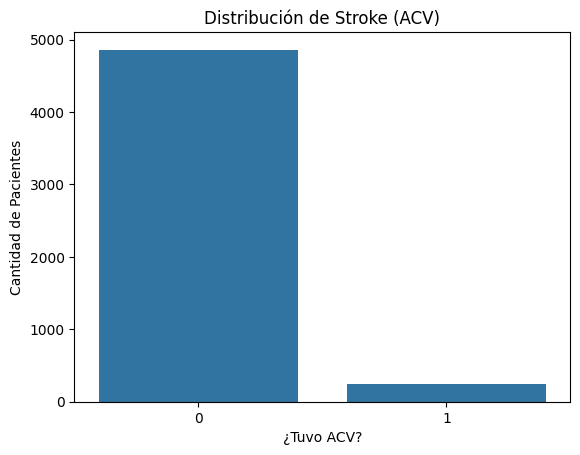

In [8]:
#Distribución de la variable objetivo
sns.countplot(x='stroke', data=df)
plt.title("Distribución de Stroke (ACV)")
plt.xlabel("¿Tuvo ACV?")
plt.ylabel("Cantidad de Pacientes")
plt.show()

Si la mayoría tiene stroke=0, entonces hay un desbalance de clases, importante más adelante en el modelado.

En este dataset es común que menos del 5% haya tenido un ACV.

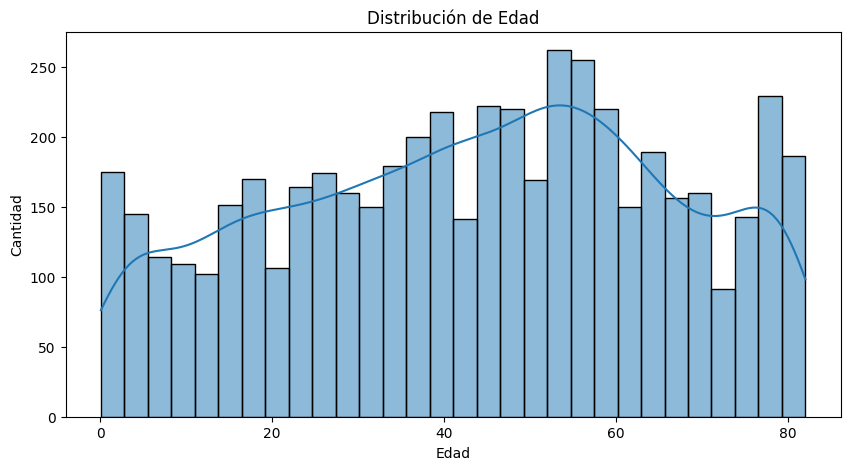

In [9]:
# Distribución de edad
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='age', bins=30, kde=True)
plt.title("Distribución de Edad")
plt.xlabel("Edad")
plt.ylabel("Cantidad")
plt.show()

# Conclusión posible:

La mayoría de pacientes están entre los 40 y 80 años. Esto tiene sentido, ya que el riesgo de ACV aumenta con la edad.

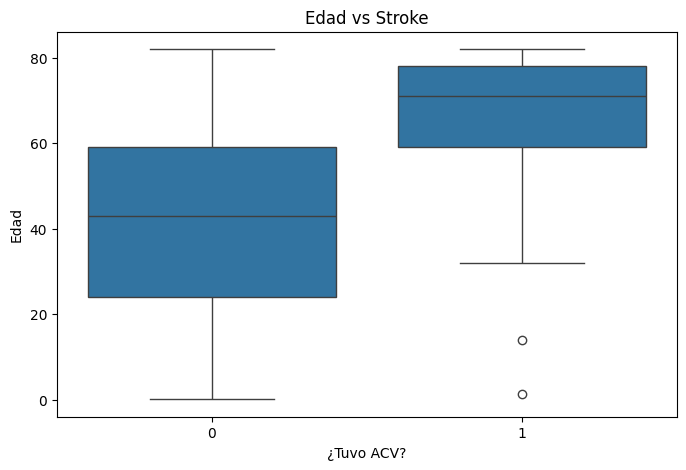

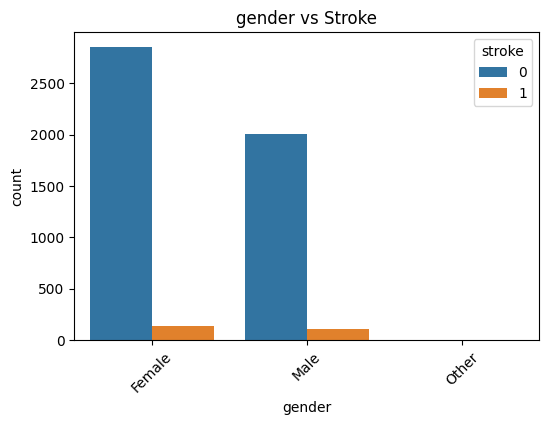

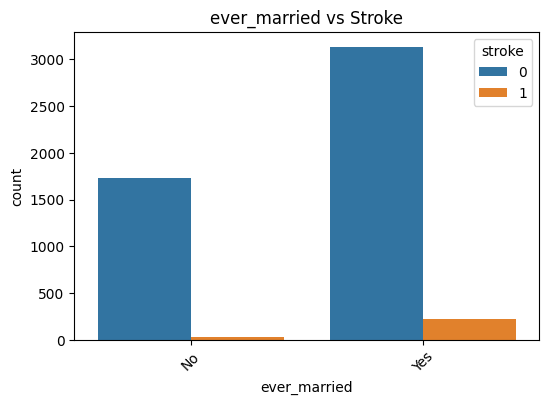

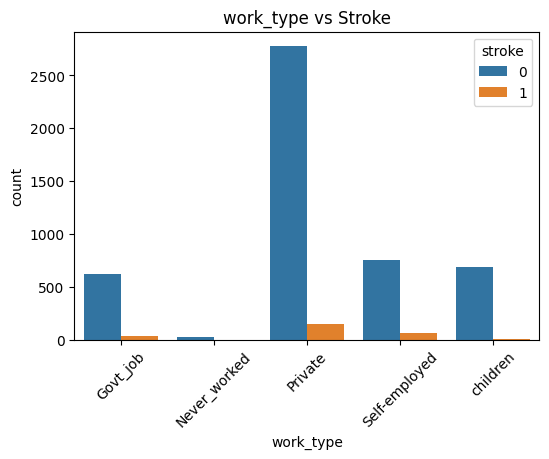

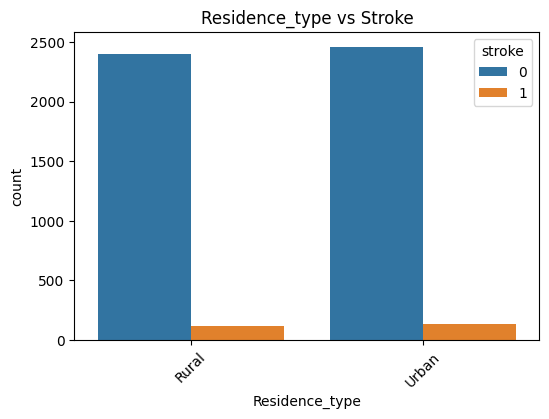

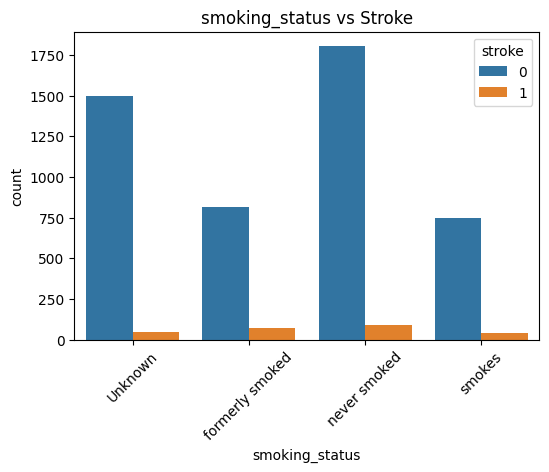

In [11]:
# Comparar tasas de ACV por categoría (ej: género, tipo de trabajo)
# - Visualizar cómo se distribuye stroke dentro de cada categoría.
# - Identificar si ciertas categorías tienen más riesgo (por ejemplo: fumadores, desempleados, etc).

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue='stroke')
    plt.title(f"{col} vs Stroke")
    plt.xticks(rotation=45)
    plt.show()

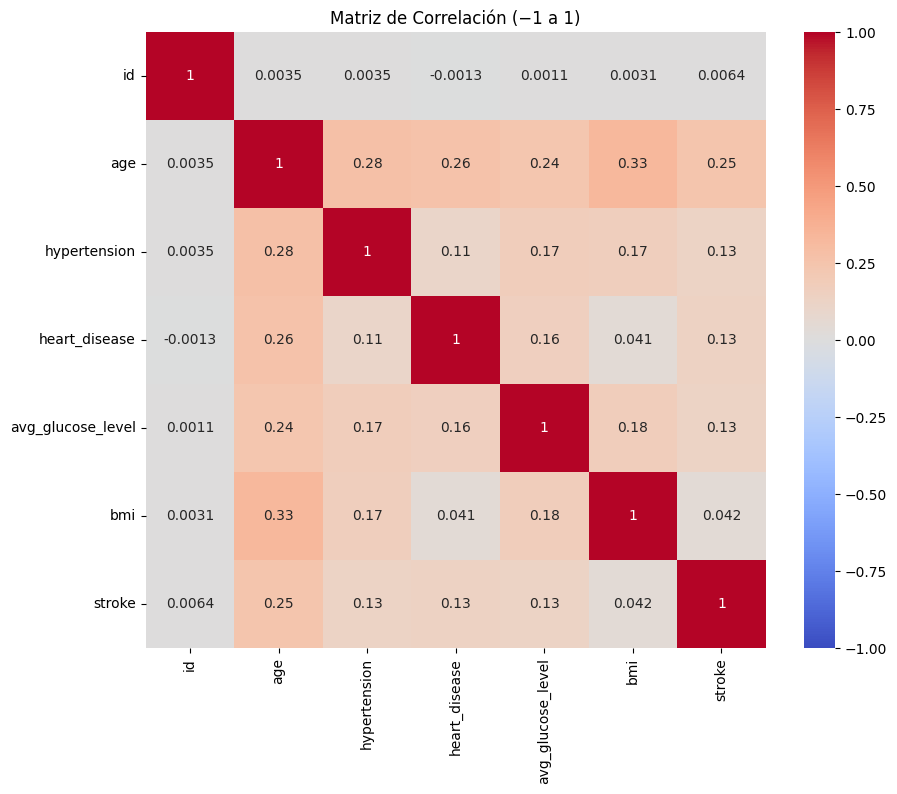

In [12]:
# Mapa de calor de correlaciones

# Filtrar solo columnas numéricas
numericas = df.select_dtypes(include=['float64', 'int64'])

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numericas.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlación (−1 a 1)")
plt.show()

# **Tratamiento y Curación del Dataset**

Este paso asegura que los datos estén limpios, completos y listos para el modelado.

In [13]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


 Valores faltantes encontrados:
La columna bmi tiene 201 valores nulos.

Esto es importante porque bmi (índice de masa corporal) es una variable numérica relevante para predecir ACV (stroke), por lo que no debemos eliminarla sin pensar.

In [ ]:
# Opción 1: Rellenar con la media (promedio)

df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

- Ventaja: Mantiene todos los registros.

- Riesgo: Si hay muchos valores extremos (outliers), la media puede no representar bien la población.



In [16]:
# Opción 2: Rellenar con la mediana, elegimos esta

df['bmi'] = df['bmi'].fillna(df['bmi'].median())

- Ventaja: Menos sensible a outliers.

- En la práctica médica, la mediana es una elección muy segura si hay grandes variaciones de peso/altura.



Vamos a visualizar cómo se ve la distribución de la variable bmi antes y después de imputar los valores nulos. Esto nos permite verificar si la imputación altera demasiado la distribución, lo cual es muy importante en ciencia de datos.



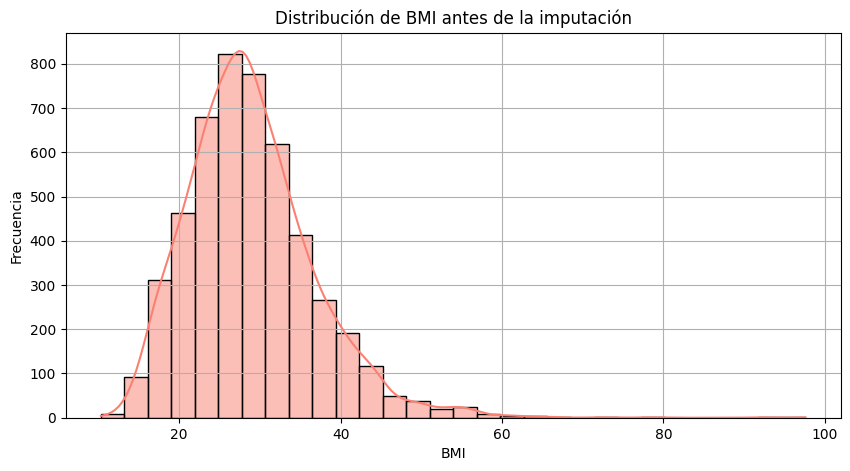

In [14]:
# Visualizar bmi antes de imputar
# Configuramos el estilo de los gráficos
plt.figure(figsize=(10,5))
sns.histplot(df['bmi'], kde=True, bins=30, color='salmon')
plt.title('Distribución de BMI antes de la imputación')
plt.xlabel('BMI')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

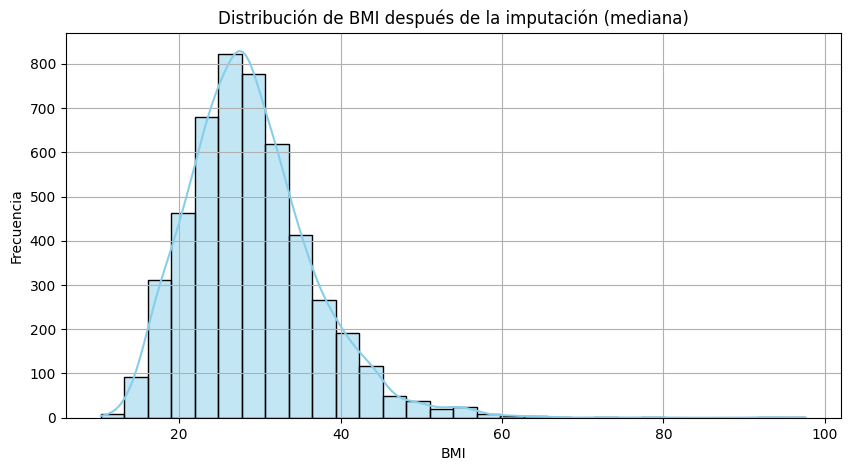

In [15]:
# Visualizar bmi después de la imputación
plt.figure(figsize=(10,5))
sns.histplot(df['bmi'], kde=True, bins=30, color='skyblue')
plt.title('Distribución de BMI después de la imputación (mediana)')
plt.xlabel('BMI')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

La distribución no cambia significativamente porque imputamos con la mediana (que es robusta a outliers).

Si antes había un hueco en la distribución (por los NaN), ahora estará más "continua".

No se agregan valores extremos nuevos, y eso es bueno.

# Codificar variables categóricas con get_dummies
Queremos convertir columnas como gender, ever_married, etc., a variables numéricas porque los modelos de ML no manejan texto.

In [17]:
df_encoded = pd.get_dummies(df.drop('id', axis=1), drop_first=True)

Elimina la columna id (no aporta valor predictivo).

Convierte todas las columnas categóricas a variables dummies (0/1).

drop_first=True evita colinealidad (elimina una categoría por variable).

In [18]:
# Escalar variables numéricas
# Esto normaliza esas 3 columnas, haciéndolas comparables entre sí.

scaler = StandardScaler()
numeric_cols = ['age', 'avg_glucose_level', 'bmi']

df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

## **Modelado predictivo (Machine Learning)**
(stroke: 0 = No, 1 = Sí):

# 1. Separar variables predictoras (X) y variable objetivo (y)

In [19]:
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']
X.dtypes

,0
age,float64
hypertension,int64
heart_disease,int64
avg_glucose_level,float64
bmi,float64
gender_Male,bool
gender_Other,bool
ever_married_Yes,bool
work_type_Never_worked,bool
work_type_Private,bool


# 2. Separar en conjunto de entrenamiento y prueba
Usamos train_test_split para poder entrenar el modelo y luego evaluarlo en datos no vistos:

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # estratificamos porque el dataset está desbalanceado
)

¿Qué significa estratificar al dividir el dataset?
Cuando usamos train_test_split para dividir los datos en entrenamiento y prueba, hay una opción llamada stratify. Esto asegura que la proporción de clases (en este caso, stroke = 0 y stroke = 1) se mantenga igual en ambos conjuntos.

# 3. Elegir modelo(s) iniciales

Podemos empezar con algunos clásicos y fáciles de interpretar:

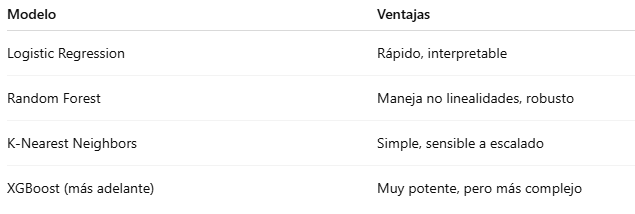

# Empezamos por regresión logística:

In [21]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

# 4. Evaluar el modelo
Vamos a revisar:

Accuracy

Matriz de confusión

Precision, Recall, F1-score (muy importante en datos desbalanceados como este)

Curva ROC

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1458
           1       1.00      0.01      0.03        75

    accuracy                           0.95      1533
   macro avg       0.98      0.51      0.50      1533
weighted avg       0.95      0.95      0.93      1533

Matriz de Confusión:
[[1458    0]
 [  74    1]]


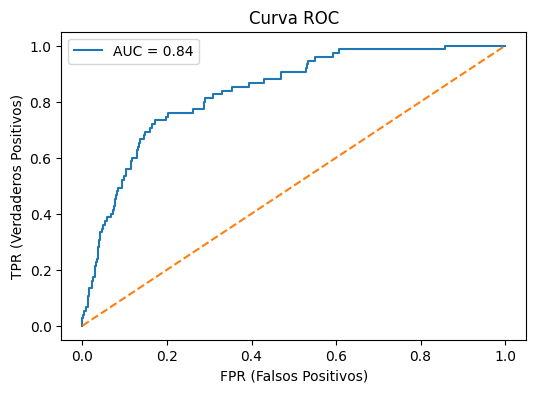

In [22]:
# Predicciones
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # probabilidades para curva ROC

# 1. Reporte
print(classification_report(y_test, y_pred))

# 2. Matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# 3. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FPR (Falsos Positivos)')
plt.ylabel('TPR (Verdaderos Positivos)')
plt.title('Curva ROC')
plt.legend()
plt.show()

- Accuracy general = 0.95 (95%): 95% de las predicciones fueron correctas en total.

- Para la clase 0 (mayoritaria):

- Precision 0.95 y recall 1.00 → El modelo predice casi todos los casos negativos correctamente y no pierde ningún caso negativo.

- Para la clase 1 (minoritaria, stroke):

- Precision 1.00 pero recall 0.01 → El modelo casi nunca detecta casos reales de stroke (recall bajísimo), pero cuando predice que es stroke, lo hace correctamente (precisión perfecta).

- Esto indica que el modelo predice muy pocos casos positivos (stroke=1), casi siempre predice negativo para esos casos.

- F1-score para clase 1 es 0.03, muy bajo → pobre desempeño para detectar pacientes con stroke.

- Macro avg y weighted avg están sesgados por la clase mayoritaria y la cantidad de muestras.

# **TEORIA**

# Matriz de confusión

- Para un problema médico, los FN son peligrosos: pacientes con stroke no detectados.

- Los FP también tienen costo (ansiedad, pruebas innecesarias), pero a menudo se prioriza minimizar FN.

# Precisión (Precision)

- De todos los casos que el modelo predijo como stroke, ¿cuántos realmente tenían stroke?

- Alta precisión = pocas falsas alarmas (FP).

# Sensibilidad o Recall (también llamada Tasa de verdaderos positivos)

- De todos los casos que realmente tenían stroke, ¿cuántos detectó el modelo?

- Alta sensibilidad = pocos casos perdidos (FN).

- En medicina, recall suele ser más importante para detectar todos los pacientes con la enfermedad.

# F1-score

- Es el promedio armónico entre precisión y recall.

- Balancea ambos; útil cuando las clases están desbalanceadas.

# Exactitud o Accuracy

- Proporción de predicciones correctas en general.

- No es buena métrica si hay mucho desbalance, porque el modelo puede predecir siempre la clase mayoritaria y tener alta accuracy pero fallar en la minoritaria.

# Curva ROC y AUC

- ROC (Receiver Operating Characteristic) curva que mide la relación entre Tasa de Verdaderos Positivos (Recall) y Tasa de Falsos Positivos (FPR) para distintos umbrales de decisión.

- El área bajo la curva (AUC) es un indicador del rendimiento general del modelo (de 0.5 a 1).

- AUC cercano a 1 indica buen modelo.

- Permite evaluar el trade-off entre sensibilidad y especificidad.

¿Qué significa esto?

- El modelo está "ignorando" casi todos los casos positivos. Esto es típico cuando el dataset está muy desbalanceado y el modelo aprende a predecir la clase mayoritaria para maximizar accuracy.

- Recall bajísimo para stroke (1) implica que el modelo NO está detectando casi ningún paciente con ACV, lo cual es crítico y un problema médico muy serio.

- La precisión 1.00 para clase 1 es engañosa: porque muy pocas veces predice la clase positiva, pero cuando lo hace, acierta.



# Qué hacer para mejorar esto
1. Manejar el desbalance
Usar técnicas como:

  - SMOTE (Synthetic Minority Over-sampling Technique) para aumentar muestras de la clase minoritaria.

  - Ajustar pesos en el modelo para que errores en la clase minoritaria tengan más penalización.

  - Undersampling de la clase mayoritaria (con cuidado, nosotros no lo vamos a hacer).

2. Modificar umbral de decisión
  El modelo predice clase 1 solo si la probabilidad supera cierto umbral (por defecto 0.5).

  Reducir ese umbral puede aumentar el recall pero bajar precision (más falsos positivos).

  Podemos ajustar ese umbral para balancear precision y recall según la prioridad clínica.

3. Probar modelos más complejos

  Random Forest, XGBoost suelen manejar mejor clases desbalanceadas y relaciones no lineales.

  Ajustar hiperparámetros, usar validación cruzada.

# Vamos a probar un modelo Random Forest para ver si mejora la detección de casos positivos (stroke=1), y después comparamos las métricas con las del modelo actual.

Matriz de Confusión:
[[1456    2]
 [  74    1]]

Reporte de Clasificación:
               precision    recall  f1-score   support

No Stroke (0)       0.95      1.00      0.97      1458
   Stroke (1)       0.33      0.01      0.03        75

     accuracy                           0.95      1533
    macro avg       0.64      0.51      0.50      1533
 weighted avg       0.92      0.95      0.93      1533

AUC: 0.808


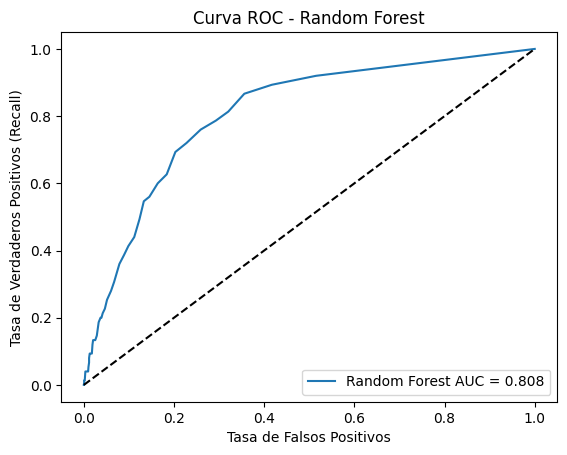

In [23]:
# Ya tenemos del modelo anterior:
# X_train, X_test, y_train, y_test: datos divididos en train/test


# 1. Crear y entrenar modelo Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')  #class_weight='balanced' ayuda a que el modelo tenga más sensibilidad para la clase minoritaria.

# 'balanced' ajusta pesos según frecuencia de clases

rf_model.fit(X_train, y_train)

# 2. Predecir clases y probabilidades en test
y_pred = rf_model.predict(X_test)               # predict_proba devuelve la probabilidad de cada clase, útil para curva ROC. Se usa el conjunto test para evaluar el desempeño real.
y_scores = rf_model.predict_proba(X_test)[:,1]  # probabilidad clase 1

# 3. Métricas y matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Stroke (0)', 'Stroke (1)']))

# 4. Curva ROC y AUC
auc = roc_auc_score(y_test, y_scores)
print(f"AUC: {auc:.3f}")

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr, label=f'Random Forest AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.show()

# Conclusión

- Random Forest no mejoró la sensibilidad (recall) para la clase minoritaria en este primer intento.

- Sí mejoró precision para clase 1, pero eso no ayuda si no detecta casos reales.

- Esto suele pasar porque el dataset está muy desbalanceado.

# Próximos pasos para mejorar recall
1. Ajustar umbral de decisión
  - Actualmente predice positivo sólo si probabilidad > 0.5.

  - Bajando ese umbral, podemos aumentar detección (recall), aunque suban falsos positivos.

    Ejemplo: probar umbral 0.2 o 0.1 y medir métricas.

2. Oversampling con SMOTE (aumentar casos minoritarios sintéticos)
Generar más ejemplos sintéticos para la clase minoritaria y reentrenar.

3. Ajustar hiperparámetros más finos o probar modelos que manejen mejor el desbalance (XGBoost con scale_pos_weight).


# 1. Ajustar el umbral de decisión para mejorar recall
El objetivo es bajar el umbral de clasificación para la clase 1, por ejemplo a 0.2 o 0.1, para que el modelo sea más sensible y prediga más positivos. Esto generalmente aumenta recall pero reduce precisión.

In [24]:
from sklearn.metrics import precision_recall_fscore_support
# Probabilidades de la clase positiva (stroke=1)
y_scores = rf_model.predict_proba(X_test)[:, 1]

# Función para evaluar métricas a distintos umbrales
def eval_threshold(threshold):
    y_pred_thresh = (y_scores >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary')
    print(f"Umbral = {threshold:.2f} -> Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")

# Probar varios umbrales
for t in np.arange(0.1, 0.6, 0.1):
    eval_threshold(t)

Umbral = 0.10 -> Precision: 0.158, Recall: 0.600, F1-score: 0.251
Umbral = 0.20 -> Precision: 0.202, Recall: 0.253, F1-score: 0.225
Umbral = 0.30 -> Precision: 0.212, Recall: 0.093, F1-score: 0.130
Umbral = 0.40 -> Precision: 0.200, Recall: 0.040, F1-score: 0.067
Umbral = 0.50 -> Precision: 0.333, Recall: 0.013, F1-score: 0.026


Bajando el umbral a 0.10, el recall subió a 0.60 (detecta el 60% de los casos reales de stroke), que es un salto enorme.

Sin embargo, la precisión cae mucho a 0.158, es decir, hay muchos falsos positivos (el modelo predice mucho stroke cuando no lo es).

El F1-score mejora a 0.251 en 0.10, un valor bajo pero mejor que antes.

A medida que subimos el umbral, baja recall y sube precision, como es esperado.

Para aplicaciones médicas es común preferir mayor recall para no perder casos positivos, aceptando falsos positivos.

Umbral 0.10 puede ser un buen punto para un balance más clínico, pero hay que analizar impacto de falsos positivos (más alarmas falsas).

# 2. Ahora probamos SMOTE para ver si al balancear clases el modelo aprende mejor y mejora las métricas.

In [25]:
from imblearn.over_sampling import SMOTE
# Aplicamos SMOTE sobre el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribución antes de SMOTE:", np.bincount(y_train))
print("Distribución después de SMOTE:", np.bincount(y_train_res))

# Entrenar un nuevo Random Forest con los datos balanceados
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_res, y_train_res)

# Predecir en el conjunto de test original (sin SMOTE)
y_pred_smote = rf_smote.predict(X_test)

# Evaluar rendimiento
print("\nMatriz de Confusión (con SMOTE):")
print(confusion_matrix(y_test, y_pred_smote))

print("\nReporte de Clasificación (con SMOTE):")
print(classification_report(y_test, y_pred_smote, target_names=["No Stroke (0)", "Stroke (1)"]))

Distribución antes de SMOTE: [3403  174]
Distribución después de SMOTE: [3403 3403]

Matriz de Confusión (con SMOTE):
[[1331  127]
 [  50   25]]

Reporte de Clasificación (con SMOTE):
               precision    recall  f1-score   support

No Stroke (0)       0.96      0.91      0.94      1458
   Stroke (1)       0.16      0.33      0.22        75

     accuracy                           0.88      1533
    macro avg       0.56      0.62      0.58      1533
 weighted avg       0.92      0.88      0.90      1533



- Verdaderos negativos (TN): 1331 → bien clasificados como No Stroke.

- Verdaderos positivos (TP): 25 → bien clasificados como Stroke.

- Falsos negativos (FN): 50 → eran Stroke, el modelo no los detectó.

- Falsos positivos (FP): 127 → predijo Stroke pero eran No Stroke.

 **Análisis del Reporte de Clasificación**

  Para clase 1 (Stroke):

- Precision = 0.16 → de todas las veces que predijo Stroke, solo el 16% eran correctas.

- Recall = 0.33 → detectó el 33% de todos los casos reales de Stroke (mejor que antes).

- F1-score = 0.22 → combinación de precision y recall, aún baja pero mejora clara respecto al modelo original.

General:

- Accuracy = 0.88 → se mantiene alta, aunque ahora hay más falsos positivos (esperable con SMOTE).



# 3. Probar XGBoost con scale_pos_weight

Qué hace scale_pos_weight?

Este parámetro ajusta la penalización que XGBoost aplica a los errores en la clase minoritaria.

In [26]:
from xgboost import XGBClassifier

# Calcular el peso para balancear
scale_pos_weight = np.bincount(y_train)[0] / np.bincount(y_train)[1]
print("scale_pos_weight:", round(scale_pos_weight, 2))

# Entrenar modelo XGBoost
xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# Predecir en test
y_pred_xgb = xgb.predict(X_test)

# Evaluar
print("\nMatriz de Confusión (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nReporte de Clasificación (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=["No Stroke (0)", "Stroke (1)"]))


scale_pos_weight: 19.56

Matriz de Confusión (XGBoost):
[[1414   44]
 [  60   15]]

Reporte de Clasificación (XGBoost):
               precision    recall  f1-score   support

No Stroke (0)       0.96      0.97      0.96      1458
   Stroke (1)       0.25      0.20      0.22        75

     accuracy                           0.93      1533
    macro avg       0.61      0.58      0.59      1533
 weighted avg       0.92      0.93      0.93      1533



## **KNN**

Matriz de Confusión:
[[1447   11]
 [  75    0]]

Reporte de Clasificación:
               precision    recall  f1-score   support

No Stroke (0)       0.95      0.99      0.97      1458
   Stroke (1)       0.00      0.00      0.00        75

     accuracy                           0.94      1533
    macro avg       0.48      0.50      0.49      1533
 weighted avg       0.90      0.94      0.92      1533

AUC: 0.603


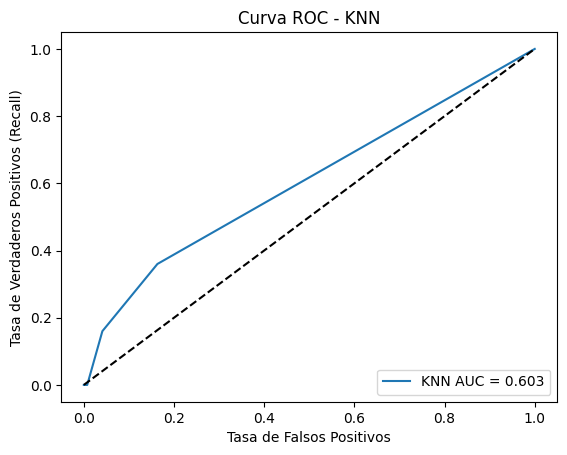

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# 1. Crear y entrenar modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train)

# 2. Predecir clases y probabilidades en test
y_pred = knn_model.predict(X_test)
y_scores = knn_model.predict_proba(X_test)[:,1]  # Probabilidad clase 1

# 3. Métricas y matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Stroke (0)', 'Stroke (1)']))

# 4. Curva ROC y AUC
auc = roc_auc_score(y_test, y_scores)
print(f"AUC: {auc:.3f}")

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr, label=f'KNN AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Curva ROC - KNN')
plt.legend(loc='lower right')
plt.show()

usar F1-score, accuracy, precision y matriz de confusión (MC) es válido para evaluar un modelo, pero no todos estos indicadores tienen el mismo peso cuando hay un desbalance de clases, como es el caso de este dataset de ACV.

1. Matriz de Confusión (MC)
  Es fundamental porque muestra los errores reales del modelo:

  TP (Verdaderos Positivos)

  TN (Verdaderos Negativos)

  FP (Falsos Positivos)

  FN (Falsos Negativos)

  Muy útil para entender qué está prediciendo mal el modelo.

  Especialmente importante en datasets desbalanceados, ya que accuracy puede ser engañosa.

2. Accuracy (Precisión Global)

- No es buena métrica en casos desbalanceados.

- Ejemplo: si el 95% de los pacientes no tienen ACV, un modelo que siempre diga “no hay ACV” tendrá 95% de accuracy, pero es inútil clínicamente.

- usarla solo como referencia, pero no como métrica principal.

3. Precision

- Mide cuántos de los positivos predichos realmente lo eran.

- Importante cuando los falsos positivos son costosos (ej., pruebas médicas innecesarias).

- En medicina, puede sacrificarse algo de precisión para aumentar recall.

4. Recall (Sensibilidad o Tasa de Verdaderos Positivos)

- Mide cuántos de los positivos reales fueron detectados

- Es la métrica más importante en medicina preventiva

- Es peor no detectar un paciente con riesgo de ACV (FN) que alarmarse por un falso positivo (FP).

5. F1-Score

- Es el promedio armónico entre precision y recall

- Muy útil cuando hay desbalance de clases.

- Resume en una sola métrica el equilibrio entre detectar bien (recall) y no alarmar sin razón (precision).






# **Optimización de KNN con GridSearchCV**

Iniciando búsqueda de grilla para KNN...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Búsqueda de grilla completada.

--- Resultados de GridSearchCV ---
Mejores hiperparámetros encontrados: {'metric': 'manhattan', 'n_neighbors': np.int64(1), 'weights': 'uniform'}
Mejor puntuación (f1_macro en validación cruzada): 0.5369

--- Evaluación del Mejor Modelo KNN en el Conjunto de Prueba ---
Matriz de Confusión:
[[1387   71]
 [  67    8]]

Reporte de Clasificación:
               precision    recall  f1-score   support

No Stroke (0)       0.95      0.95      0.95      1458
   Stroke (1)       0.10      0.11      0.10        75

     accuracy                           0.91      1533
    macro avg       0.53      0.53      0.53      1533
 weighted avg       0.91      0.91      0.91      1533

AUC del mejor KNN: 0.5290


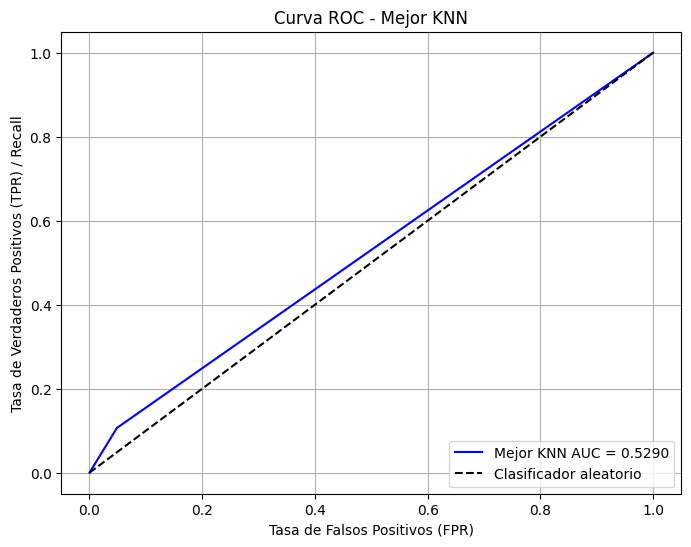

In [ ]:
from sklearn.model_selection import GridSearchCV

# Paso 1: Definir el modelo
knn_base_model = KNeighborsClassifier()

# Paso 2: Definir la grilla de hiperparámetros a probar
# n_neighbors: número de vecinos a considerar
# weights: cómo se ponderan los votos de los vecinos ('uniform' o 'distance')
# metric: la métrica de distancia a usar ('euclidean', 'manhattan', etc.)
param_grid = {
    'n_neighbors': np.arange(1, 31),  # Probar de 1 a 30 vecinos
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Paso 3: Configurar GridSearchCV
# estimator: modelo KNN base
# param_grid: el diccionario de hiperparámetros
# cv: número de folds para la validación cruzada (ej. 5)
# scoring: la métrica a optimizar. 'f1_macro' es bueno para clases desbalanceadas
#          Si 'f1_macro' no funciona, podemos usar 'f1' si es binario puro y queremos el F1 de la clase positiva
#          O podemos crear un scorer personalizado si necesitamos algo específico
# n_jobs: -1 usa todos los núcleos de CPU para acelerar el proceso
grid_search_knn = GridSearchCV(
    estimator=knn_base_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',  # O 'roc_auc' si preferimos optimizar AUC
    n_jobs=-1,
    verbose=1 # Muestra el progreso
)

# Paso 4: Ejecutar la búsqueda de grilla en los datos de entrenamiento
print("Iniciando búsqueda de grilla para KNN...")
grid_search_knn.fit(X_train, y_train)
print("Búsqueda de grilla completada.")

# Paso 5: Mostrar los mejores hiperparámetros encontrados
print("\n--- Resultados de GridSearchCV ---")
print(f"Mejores hiperparámetros encontrados: {grid_search_knn.best_params_}")
print(f"Mejor puntuación (f1_macro en validación cruzada): {grid_search_knn.best_score_:.4f}")

# Paso 6: Obtener el mejor modelo
best_knn_model = grid_search_knn.best_estimator_

# Paso 7: Evaluar el mejor modelo en el conjunto de prueba
print("\n--- Evaluación del Mejor Modelo KNN en el Conjunto de Prueba ---")
y_pred_best = best_knn_model.predict(X_test)
y_scores_best = best_knn_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva

# Métricas y matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_best))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_best, target_names=['No Stroke (0)', 'Stroke (1)']))

# Curva ROC y AUC
auc_best = roc_auc_score(y_test, y_scores_best)
print(f"AUC del mejor KNN: {auc_best:.4f}")

fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_scores_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, label=f'Mejor KNN AUC = {auc_best:.4f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curva ROC - Mejor KNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

